# Example of calculation of a stable geotherm

Copyright 2021 Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goal of the notebook**: Estimate and plot a steady-state thermal gradient for the continental lithosphere considering a two-layer model (crust vs lithospheric mantle) using the Turcotte and Schubert (1982) model.

In [1]:
# import the required Python scientific libraries
import numpy as np
import matplotlib.pyplot as plt

# set a custom figure style (this is optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'white'

## Step 1: Set the steady-state geotherm model

Flow laws require knowledge of temperature variation with depth (aka "the geotherm") since the processes that produce creep are temperature dependent. This means that before estimating a full lithosphere strength envelope we need to make a model of how the temperature varies with the depth. To do this, let's make some assumptions first:

- the geotherm is in **steady-state** and thus temperature only vary as a function of depth $(\frac{dT}{dz})$.
- In the lithosphere, heat is transferred by conduction.
- The temperature gradient depends on heat conduction plus the heat produced due to radioactive decay.
- Radioactive heat production in the crust and the mantle are independent of depth.

Considering these assumptions, Turcotte and Schubert (1982) proposed an analytical solution of the heat equation that have three terms

$T_z = T_{z0} + \frac{J_q}{K}(z - z_0) - \frac{A_0}{2K}(z - z_0)^2$

- $T_z$ is the temperature variation with depth $(\frac{dT}{dz})$.
- The **first term**, $T_{z0}$, is the temperature at the minimum depth considered in the model (e.g. at the surface of the Earth or any other).
- The **second term**, $\frac{J_q}{K}(z - z_0)$ account for the heat conduction and includes the average heat flux ($J_q$), the coefficient of thermal conductivity ($K$), and the upper and lower depth limits $(z - z_0)$.
- The **third term**, $\frac{A_0}{2K}(z - z_0)^2$ accounts for the heat production and it includes a new parameter called the average heat productivity ($A_0$).

This equation allows us to estimate the temperature gradient from the surface temperature if we know the parameters $J_q$, $K$, and $A_0$. Now, let's convert this into a Python function.

In [2]:
def turcotte_schubert_model(depths, thermal):
    """ Apply the equation (model) of Turcotte and Schubert (1982) (ts) to estimate
    a steady-state geotherm (i.e. the T at a given depth)

    Parameters (arrays or scalar with positive values)
    ----------
    depths : an array with the depths

    thermal : a tuple of dim 4 (T0, Jq, A, K) where
        T0 is the temperature at the min depth [C degrees]
        Jq is the average heat flux [mW m**-2]
        A is the average heat productivity [microW m**-3]
        K is the coefficient of thermal conductivity [W m**-1 K**-1]

    Assumptions
    -----------
    - the temperature only vary as a function of depth (not in time, i.e. steady-state geotherm).
    - Heat is transferred by conduction (as in the lithosphere).
    - The temperature gradient depends on heat conduction plus the heat produced due to radioactive decay.
    - Radioactive heat production are independent of depth.

    Returns
    -------
    The temperature in K, a float
    """
    # extract the different thermal parameters
    T0, Jq, A, K = thermal
    
    # get the min depth in the model [km]
    z0 = depths[0]
    
    return T0 + Jq / K * (depths - z0) - A / (2 * K) * (depths - z0)**2

## Step 2: Set the boundary conditions for the model

In [3]:
moho = 38.8 # Continental crust thickness [m], average from Hacker et al. (2015)
Lab = 81  # Lithosphere-asthenosphere boundary (Lab) [m], average beneath tectonically altered regions (Rychert and Shearer, 2009)
T_surf = 7.5  # surface T (taken from the KTB superdeep borehole)

# Average heat parameters for the crust and the mantle. We will store
# the different parameters within two Python object called heat_crust and
# mantle crust using the SimpleNamespace method (see Python basics for more info)
from types import SimpleNamespace
heat_crust = SimpleNamespace(Jq = 65,  # Average heat flux [mW m**-2] from Jaupar and Mareschal (2007)
                             A = 0.97, # Average rate of radiogenic heat production [microW m**-3] from Huang et al. (2013)
                             K = 2.51) # Coefficient of thermal conductivity [W m**-1 K**-1] from Sclater et al. (1980)

heat_mantle = SimpleNamespace(Jq = 34,  # from Sclater et al. (1980)
                              A = 0.01, # from Sclater et al. (1980)
                              K = 3.35) # in peridotite at room T (Sclater et al., 1980)

## Step 3: Estimate the geotherm for the crust

For this, we need to create an array containing the different crust depths and then calculate the corresponding temperature using the Turcotte and Schubert model (i.e. the ``turcotte_schubert_model`` function) and the boundary conditions set for the model. To generate the array of depths we will use a Numpy (``np.``) built-in method called ``linspace`` (meaning "linear spaced") that return evenly spaced samples over a defined interval. Specifically, the range will be between 0 and the depth of the Moho and we are going to generate a value every 10 m, so we need to generate 3800 samples (for a Moho at 38.8 km) in that interval.

In [4]:
# generate a linear spaced array of depths every 10 m
depths = np.linspace(start=0, stop=moho, num=3880)

In [5]:
# now we call the function "turcotte_schubert_model" and pass the different arguments in order
T_crust = turcotte_schubert_model(depths,
                                  thermal=(T_surf, heat_crust.Jq, heat_crust.A, heat_crust.K))

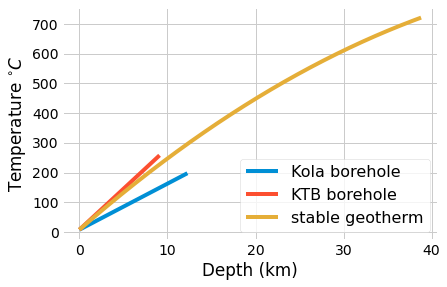

In [6]:
# plot depth vs temperature
fig1, ax = plt.subplots()

ax.plot([0, 12.262], [7.5, 197.6], label='Kola borehole')
ax.plot([0, 9.101], [7.5, 257.8], label='KTB borehole')
ax.plot(depths[depths <= moho], T_crust, label='stable geotherm')

ax.set(xlabel='Depth (km)', ylabel='Temperature $^{\circ}C$')
_ = ax.legend(loc='lower right', fontsize=16)

# For plotting the T gradient of superdeep boreholes I used
# ax.plot([x0, x1], [y0, y1]) where:
# x0 : z0 [km]
# x1 : maximum depth of the borehole [km]
# y0 : T at the start of the borehole (surface)
# y1 : T at the maximum depth of the borehole (y0 + x1 * T gradient in [K/km])

Note that the estimated geotherm is within the T gradients found in the KTB (Emmermann and Lauterjung, 1997) and Kola superdeep (Smithson et al., 2000) boreholes, where gradients are of 27.5 and 15.5 K/km respectively. In this case, very close to the gradient measured in the KTB borehole. If we want to know how is the temperature at the base of the crust, we can use the array containing all the temperatures ``T_crust`` and extract the last value (index equals -1) as follows

In [7]:
print(f'T at the Moho: {T_crust[-1]:.1f}')

T at the Moho: 721.4


## Step 4: Estimate the geotherm for the entire lithosphere

Now, let's calculate the T gradient in the lithospheric mantle. For this, we need to establish a new reference frame that defines the boundary conditions at the top of the mantle, i.e. the depth and the temperature at the Moho.

In [8]:
# generate a linear spaced array of depths every 10 m for the entire lithosphere
depths = np.linspace(start=0, stop=Lab, num=8100)
T0 = T_crust[-1]

# Estimate the T gradient
T_mantle = turcotte_schubert_model(depths[depths > moho],
                                   thermal=(T0, heat_mantle.Jq, heat_mantle.A, heat_mantle.K))

# Stack the two arrays in sequence "horizontally" -> hstack
T_lithosphere = np.hstack((T_crust, T_mantle))

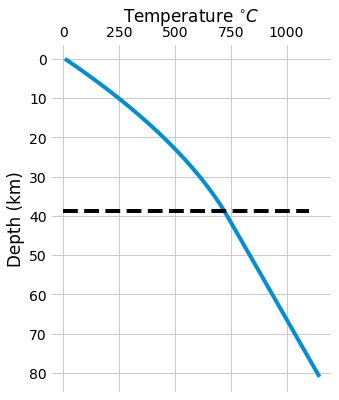

In [9]:
# initialize the figure
fig2, ax = plt.subplots(figsize=(4.5, 6))

# tweak the figure axe so that the depth is shown on the y-axis downwards
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# plot the data
ax.plot(T_lithosphere, depths)
ax.plot([0, 1100], [moho, moho], color='black', linestyle='dashed')
_ = ax.set(xlabel='Temperature $^{\circ}C$', ylabel='Depth (km)')

## Step 5: Discussing the validity of the model

For reference, let's plot the $Al_2SiO_4$ stability field in the depth vs temperature space according to Holdoway data.

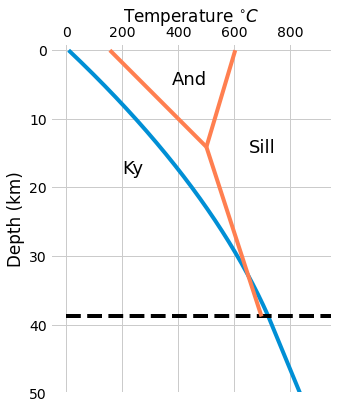

In [10]:
# set some data
ro_crust = 2750  # average rock density in the crust [kg/m**3]
g = 9.80665      # average gravitational acceleration [m/s**2]
tp_T = 500       # Al2SiO5 triple point T in C degrees
tp_P = 380000    # Al2SiO5 triple point P in Pas
tp_depth = tp_P / (ro_crust * g)
Ky_And_T = 155    # Ky-And transition at room P in C degrees
And_Sill_T = 603  # And-Sill transition at room P in C degrees
Ky_Sill_T = 697   # ~Ky-Sill transition at Moho (38.8 km) P in C degrees

# make the plot
fig3, ax = plt.subplots(figsize=(4.5, 6))

# tweak the figure so that the depth is shown on the y-axis downwards
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Plot the geotherm and the moho
ax.plot(T_lithosphere, depths)
ax.plot([0, 1100], [moho, moho], color='black', linestyle='dashed')

# plot Al2SiO4 stability fields
ax.plot([Ky_And_T, tp_T], [0, tp_depth], color='coral')  # Ky-And line
ax.plot([tp_T, And_Sill_T], [tp_depth, 0], color='coral')  # And-Sill line
ax.plot([tp_T, Ky_Sill_T], [tp_depth, moho], color='coral')  # Ky-Sill line
ax.annotate(text='And', xy=(375, 5), fontsize=18)
ax.annotate(text='Sill', xy=(650, 15), fontsize=18)
ax.annotate(text='Ky', xy=(200, 18), fontsize=18)

# focus on the crust
ax.set_xlim(xmax=950)
ax.set_ylim(ymin=50, ymax=-1)
_ = ax.set(xlabel='Temperature $^{\circ}C$', ylabel='Depth (km)')

We observe that the calculated geothermal never enters the stability field of the andalusite but rather that of the sillimanite near the Moho discontinuity (at ~33 km depth)